# EDA for Content Based Recommendation System

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
%reload_ext sql
%sql duckdb:///movies_data.duckdb

Found pyproject.toml from 'C:\Users\jpjon\Documents\Ploomber\sql\mini-projects\movie-rec-system'

In [2]:
%sqlcmd columns -t movies

c:\Users\jpjon\anaconda3\envs\sqlenv\lib\site-packages\sql\inspect.py:182: SAWarning: Did not recognize type 'list' of column 'genre_ids'
  columns = inspector.get_columns(name, schema) or []


name,type,nullable,default,autoincrement,comment
genre_ids,NULL,True,None,False,None
id,INTEGER,True,None,False,None
original_language,VARCHAR,True,None,False,None
overview,VARCHAR,True,None,False,None
popularity,DOUBLE_PRECISION,True,None,False,None
release_date,TIMESTAMP,True,None,False,None
title,VARCHAR,True,None,False,None
vote_average,DOUBLE_PRECISION,True,None,False,None
vote_count,INTEGER,True,None,False,None


In [3]:
%sqlcmd columns -t genres

name,type,nullable,default,autoincrement,comment
id,INTEGER,True,None,False,None
name,VARCHAR,True,None,False,None


In [4]:
%%sql 
SELECT *
FROM movies

Running query in 'duckdb:///movies_data.duckdb'

genre_ids,id,original_language,overview,popularity,release_date,title,vote_average,vote_count
"[16, 35, 10751, 14, 10749]",976573,en,"In a city where fire, water, land and air residents live together, a fiery young woman and a go-with-the-flow guy will discover something elemental: how much they have in common.",4863.437,2023-06-14 00:00:00,Elemental,7.8,1239
"[53, 28]",724209,en,An intelligence operative for a shadowy global peacekeeping agency races to stop a hacker from stealing its most valuable — and dangerous — weapon.,3752.86,2023-08-09 00:00:00,Heart of Stone,6.9,629
"[16, 28, 12]",569094,en,"After reuniting with Gwen Stacy, Brooklyn’s full-time, friendly neighborhood Spider-Man is catapulted across the Multiverse, where he encounters the Spider Society, a team of Spider-People charged with protecting the Multiverse’s very existence. But when the heroes clash on how to handle a new threat, Miles finds himself pitted against the other Spiders and must set out on his own to save those he loves most.",2374.865,2023-05-31 00:00:00,Spider-Man: Across the Spider-Verse,8.5,3625
"[28, 12, 878]",667538,en,"When a new threat capable of destroying the entire planet emerges, Optimus Prime and the Autobots must team up with a powerful faction known as the Maximals. With the fate of humanity hanging in the balance, humans Noah and Elena will do whatever it takes to help the Transformers as they engage in the ultimate battle to save Earth.",2134.463,2023-06-06 00:00:00,Transformers: Rise of the Beasts,7.5,2865
"[35, 12, 14]",346698,en,"Barbie and Ken are having the time of their lives in the colorful and seemingly perfect world of Barbie Land. However, when they get a chance to go to the real world, they soon discover the joys and perils of living among humans.",1860.335,2023-07-19 00:00:00,Barbie,7.4,3240
"[28, 12, 878]",298618,en,"When his attempt to save his family inadvertently alters the future, Barry Allen becomes trapped in a reality in which General Zod has returned and there are no Super Heroes to turn to. In order to save the world that he is in and return to the future that he knows, Barry's only hope is to race for his life. But will making the ultimate sacrifice be enough to reset the universe?",1744.899,2023-06-13 00:00:00,The Flash,7.0,2395
"[28, 878, 27]",615656,en,An exploratory dive into the deepest depths of the ocean of a daring research team spirals into chaos when a malevolent mining operation threatens their mission and forces them into a high-stakes battle for survival.,1701.916,2023-08-02 00:00:00,Meg 2: The Trench,6.9,520
"[28, 27, 53]",1006462,en,A horde of giant hungry alligators is unleashed on a group of in-transit prisoners and their guards after a massive hurricane floods Louisiana.,1623.891,2023-07-14 00:00:00,The Flood,6.9,137
"[35, 10749]",884605,en,"On the brink of losing her childhood home, Maddie discovers an intriguing job listing: wealthy helicopter parents looking for someone to “date” their introverted 19-year-old son, Percy, before he leaves for college. To her surprise, Maddie soon discovers the awkward Percy is no sure thing.",1591.22,2023-06-15 00:00:00,No Hard Feelings,7.1,753
"[27, 9648, 53]",614479,en,"To put their demons to rest once and for all, Josh Lambert and a college-aged Dalton Lambert must go deeper into The Further than ever before, facing their family's dark past and a host of new and more horrifying terrors that lurk behind the red door.",1420.728,2023-07-05 00:00:00,Insidious: The Red Door,6.9,912


In [5]:
%%sql 
SELECT *
FROM genres

Running query in 'duckdb:///movies_data.duckdb'

id,name
28,Action
12,Adventure
16,Animation
35,Comedy
80,Crime
99,Documentary
18,Drama
10751,Family
14,Fantasy
36,History


In [117]:
%%sql --save genre_names
WITH ExpandedGenres AS (
    SELECT 
        m.id AS movie_id,
        mg.movie_genre_id,
        g.name AS genre_name
    FROM 
        (SELECT UNNEST(movies.genre_ids) as movie_genre_id, movies.id FROM movies) AS mg
    JOIN 
        movies m ON mg.id = m.id
    JOIN 
        genres g ON mg.movie_genre_id = g.id
)

SELECT
    movie_id,
    STRING_AGG(genre_name, ', ') AS genre_names
FROM 
    ExpandedGenres
GROUP BY 
    movie_id;

Running query in 'duckdb:///movies_data.duckdb'

movie_id,genre_names
976573,"Animation, Comedy, Family, Fantasy, Romance"
724209,"Thriller, Action"
569094,"Animation, Action, Adventure"
667538,"Action, Adventure, Science Fiction"
346698,"Comedy, Adventure, Fantasy"
298618,"Action, Adventure, Science Fiction"
615656,"Action, Science Fiction, Horror"
1006462,"Action, Horror, Thriller"
884605,"Comedy, Romance"
614479,"Horror, Mystery, Thriller"


Movies with 0 vote_counts are usually unreleased. Filtering this out allows for recommendations for only available movies.

In [118]:
%%sql df << --save full_movie_data
SELECT gn.genre_names, m.id, m.original_language,
       m.overview, m.popularity, m.release_date,
       m.title, m.vote_average, m.vote_count
FROM genre_names gn
JOIN movies m
ON gn.movie_id = m.id
WHERE m.vote_count != 0

Generating CTE with stored snippets: 'genre_names'

Running query in 'duckdb:///movies_data.duckdb'

Plotting using saved snippet : full_movie_data

Text(0.5, 0, 'Popularity')

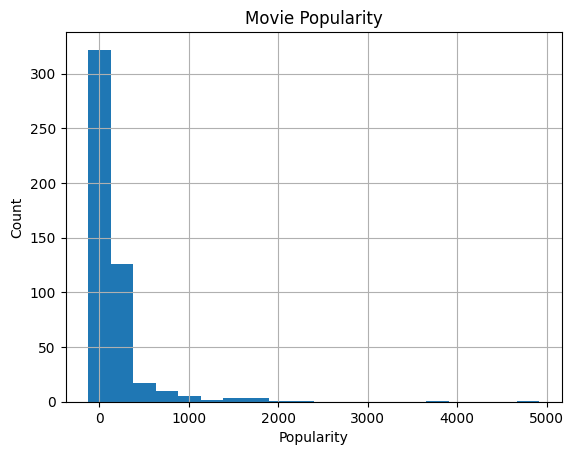

In [109]:
ax = %sqlplot histogram --table full_movie_data --column popularity --bins 20
ax.grid()
ax.set_title("Movie Popularity")
ax.set_xlabel("Popularity")

Plotting using saved snippet : full_movie_data

Text(0.5, 0, 'Vote Score')

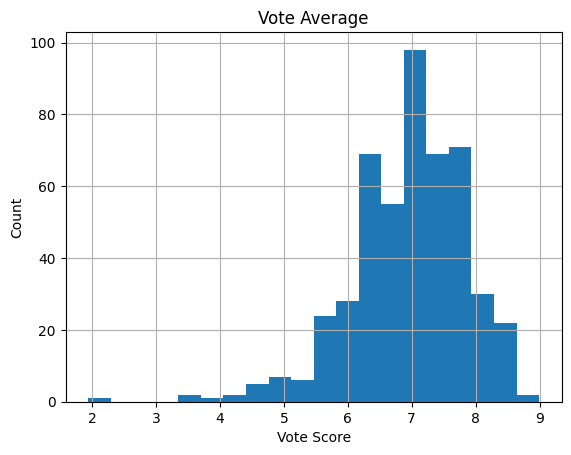

In [110]:
ax = %sqlplot histogram --table full_movie_data --column vote_average --bins 20
ax.grid()
ax.set_title("Vote Average")
ax.set_xlabel("Vote Score")

Plotting using saved snippet : full_movie_data

Text(0.5, 0, 'Votes')

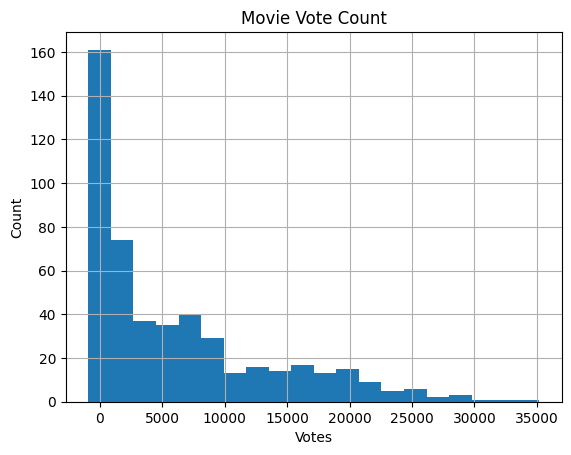

In [112]:
ax = %sqlplot histogram --table full_movie_data --column vote_count --bins 20
ax.grid()
ax.set_title("Movie Vote Count")
ax.set_xlabel("Votes")

In [120]:
df = pd.DataFrame(df)  # noqa F821

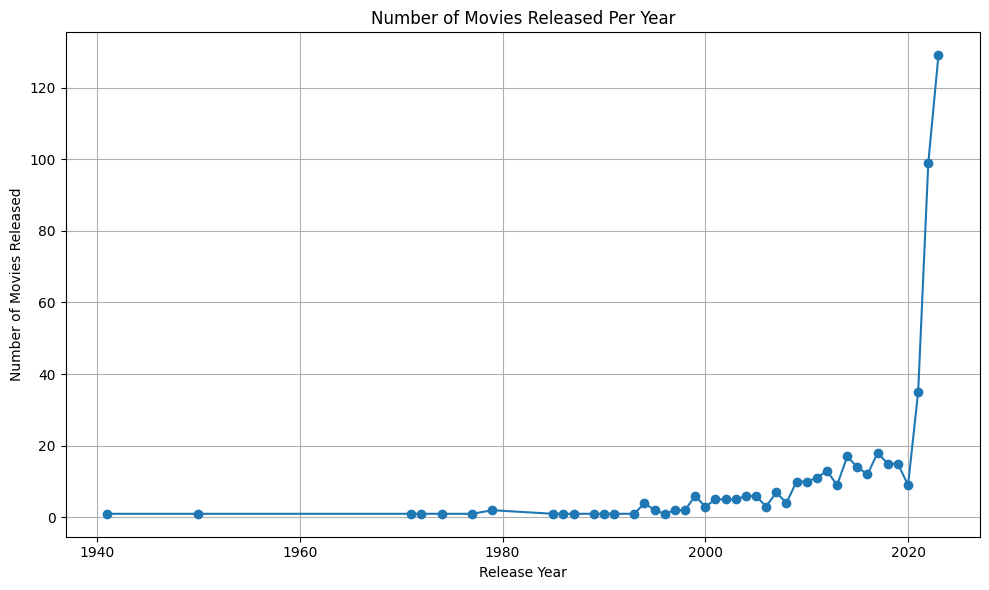

In [126]:
df["release_date"] = pd.to_datetime(df["release_date"])

df["release_year"] = df["release_date"].dt.year

movie_counts_by_year = df.groupby("release_year").size()

plt.figure(figsize=(10, 6))
plt.plot(movie_counts_by_year.index, movie_counts_by_year.values, marker="o")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies Released")
plt.title("Number of Movies Released Per Year")
plt.tight_layout()
plt.grid()
plt.show()

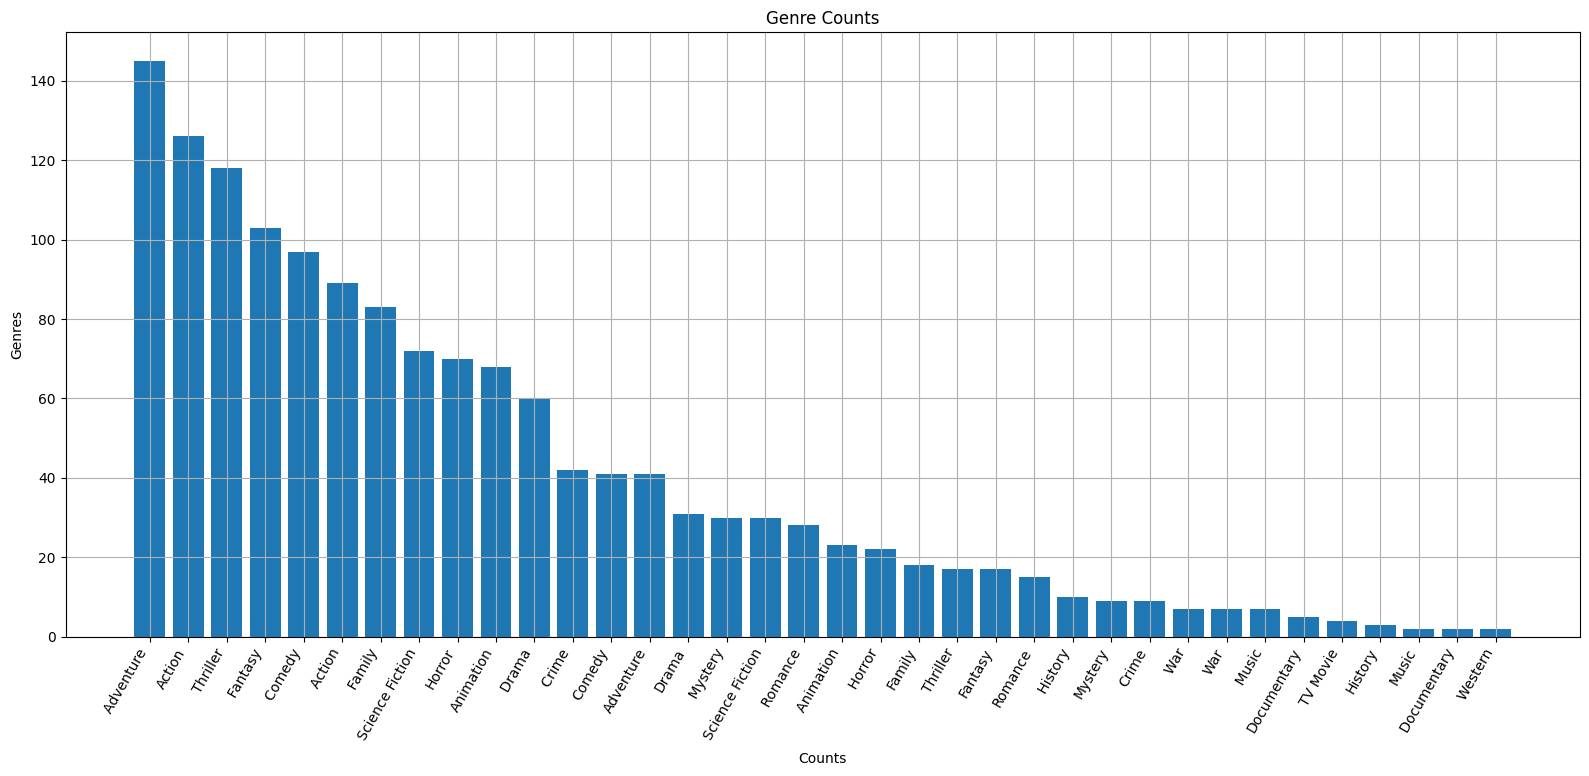

In [147]:
df["genre_names"] = df["genre_names"].astype(str)


def get_genre_count(df):
    genre_counts = dict()

    for genres in df["genre_names"]:
        genre_list = genres.split(",")
        for genre in genre_list:
            if genre not in genre_counts:
                genre_counts[genre] = 1
            genre_counts[genre] += 1
    return genre_counts


genre_counts = get_genre_count(df)

sorted_genre_counts = dict(
    sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)
)

genres = list(sorted_genre_counts.keys())
counts = list(sorted_genre_counts.values())

plt.figure(figsize=(16, 7))
plt.bar(genres, counts)
plt.ylabel("Genres")
plt.xlabel("Counts")
plt.title("Genre Counts")
plt.tight_layout()
plt.xticks(rotation=60, ha="right")
plt.grid()
plt.show()

# Moving forward

Now that preliminary data wrangling and EDA has been accomplished, the next step would be to implement a content based recommendation system. 

We'll experiment using cosine TF-IDF on our movie's description and genres.